In [5]:
#MSE vs サーチケース
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

#reaction length
df = pd.read_excel('/mnt/c/CEA/all_mixtureexp15.xlsx')

l1=['Fuel','Diluent','Equivalentratio','CoefficientDiluent','Oxidizer','P0', 'T0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]',
       'Ea[KJ/kg]',
       'Lr',]

XpcaFLRDED = pd.DataFrame({'P0':df['P0']})

for i in range(len(l1)):
    XpcaFLRDED[l1[i]]=df[l1[i]]

XpcaFLRDED = XpcaFLRDED[~( XpcaFLRDED['Ea[KJ/kg]'] == 0)]

dfH2train =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'H2') | ~( XpcaFLRDED['Equivalentratio'] == 1)]
dfH2test = XpcaFLRDED[(XpcaFLRDED['Fuel'] == 'H2') & (XpcaFLRDED['Equivalentratio'] == 1)]

dfC2H2train =  dfH2train[~( dfH2train['Fuel'] == 'C2H2') | ~( dfH2train['Equivalentratio'] == 1) | ~(dfH2train['Diluent'].isnull())]
dfC2H2test =  dfH2train[(dfH2train['Fuel'] == 'C2H2') & (dfH2train['Equivalentratio'] == 1) & (dfH2train['Diluent'].isnull())]

dfC2H4train =  dfC2H2train[~( dfC2H2train['Fuel'] == 'C2H4') | ~( dfC2H2train['Equivalentratio'] == 1) | ~(dfC2H2train['Diluent'].isnull())]
dfC2H4test =  dfC2H2train[(dfC2H2train['Fuel'] == 'C2H4') & (dfC2H2train['Equivalentratio'] == 1) & (dfC2H2train['Diluent'].isnull())]

dfC2H6train =  dfC2H4train[~( dfC2H4train['Fuel'] == 'C2H6') | ~(dfC2H4train['Equivalentratio'] == 1) | ~(dfC2H4train['Diluent'].isnull()) | ~(dfC2H4train['Oxidizer'] == 'O2')]
dfC2H6test =  dfC2H4train[(dfC2H4train['Fuel'] == 'C2H6') & (dfC2H4train['Equivalentratio'] == 1) & (dfC2H4train['Diluent'].isnull()) & (dfC2H4train['Oxidizer'] == 'O2')]

dfC2H2ARtrain =  dfC2H6train[~( dfC2H6train['Fuel'] == 'C2H2') | ~( dfC2H6train['Diluent'] == 'Ar') | ~(dfC2H6train['CoefficientDiluent'] == 7)]
dfC2H2ARtest = dfC2H6train[(dfC2H6train['Fuel'] == 'C2H2') & (dfC2H6train['Diluent'] == 'Ar') & (dfC2H6train['CoefficientDiluent'] == 7)]

dfC2H2ARdiluentratio = dfC2H2ARtest

dftrainval =  dfC2H2ARtrain[~( dfC2H2ARtrain['Fuel'] == 'C2H4') | ~( dfC2H2ARtrain['Diluent'] == 'Ar') | ~(dfC2H2ARtrain['CoefficientDiluent'] == 4)]
dfC2H4ARtest = dfC2H2ARtrain[(dfC2H2ARtrain['Fuel'] == 'C2H4') & (dfC2H2ARtrain['Diluent'] == 'Ar') & (dfC2H2ARtrain['CoefficientDiluent'] == 4)]

dftrainval = dftrainval.sample(frac=1)

X_trainval = dftrainval.drop(columns=['Equivalentratio','CoefficientDiluent','Oxidizer'])
dfH2test = dfH2test.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer'])
dfC2H2test = dfC2H2test.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer'])
dfC2H4test = dfC2H4test.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer'])
dfC2H6test = dfC2H6test.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer'])
dfC2H2ARtest = dfC2H2ARtest.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer'])
dfC2H4ARtest  = dfC2H4ARtest.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer'])

XH2test = dfH2test.drop(columns=['Lr'])
XC2H2test = dfC2H2test.drop(columns=['Lr'])
XC2H4test = dfC2H4test.drop(columns=['Lr'])
XC2H6test = dfC2H6test.drop(columns=['Lr'])
XC2H2ARtest = dfC2H2ARtest.drop(columns=['Lr'])
XC2H4ARtest = dfC2H4ARtest.drop(columns=['Lr'])

yH2test = dfH2test['Lr']
yC2H2test = dfC2H2test['Lr']
yC2H4test = dfC2H4test['Lr']
yC2H6test = dfC2H6test['Lr']
yC2H2ARtest = dfC2H2ARtest['Lr']
yC2H4ARtest = dfC2H4ARtest['Lr']

X_train= X_trainval
y_train = dftrainval['Lr']

X_trains =  X_train.drop(columns=['Diluent','Fuel','Lr'])

ss = StandardScaler()
sX_train = ss.fit_transform(X_trains)
sXH2test = ss.transform(XH2test)
sXC2H2test = ss.transform(XC2H2test)
sXC2H4test = ss.transform(XC2H4test)
sXC2H6test = ss.transform(XC2H6test)
sXC2H2ARtest = ss.transform(XC2H2ARtest)
sXC2H4ARtest = ss.transform(XC2H4ARtest)
sX_train = pd.DataFrame(sX_train,columns=X_trains.columns)

In [10]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pickle

# データの読み込み
X_train = sX_train
X_testH2 = sXH2test
X_testC2H2 = sXC2H2test
X_testC2H4 = sXC2H4test
X_testC2H6 = sXC2H6test
X_testC2H2Ar = sXC2H2ARtest
X_testC2H4Ar = sXC2H4ARtest

# 記述子名のリストを取り出す
descriptor_label = X_train.columns

'''
y_train = y_train
y_testH2 = yH2test
y_testC2H2 = yC2H2test
y_testC2H4 = yC2H4test
y_testC2H6 = yC2H6test
y_testC2H2Ar = yC2H2ARtest
y_testC2H4Ar = yC2H4ARtest
'''

# One class support vector machine (OCSVM) モデルを構築する
clf = OneClassSVM(nu = 0.1)
y_train_class = clf.fit_predict(X_train)
y_test_classH2 = clf.predict(X_testH2)
y_test_classC2H2 = clf.predict(X_testC2H2)
y_test_classC2H4 = clf.predict(X_testC2H4)
y_test_classC2H6 = clf.predict(X_testC2H6)
y_test_classC2H2Ar = clf.predict(X_testC2H2Ar)
y_test_classC2H4Ar = clf.predict(X_testC2H4Ar)

# 分割面からの距離を算出
print(clf.decision_function(X_testH2))
print(clf.decision_function(X_testC2H2))
print(clf.decision_function(X_testC2H4))
print(clf.decision_function(X_testC2H6))
print(clf.decision_function(X_testC2H2Ar))
print(clf.decision_function(X_testC2H4Ar))

[-0.22146032  0.41401316  0.12107305 -0.10480261  0.17379597 -0.10054944
  0.17754018  0.12363312 -0.00229396  0.12589066  0.19300235  0.37388623
  0.56565333  0.87553498  0.32991324  0.4705227   0.95686174  0.95041067
  0.57639073  0.51464127  0.46454545  0.31092913  0.94351087  0.30777715
  0.93221824  0.93151136  0.93151136  0.50040472  0.88375138  0.92528441
  0.2423189   0.76885051  0.76573394  0.14782741  0.08655474  0.08428357
  0.19775165 -0.10225416 -0.10225416 -0.16659887 -0.16659887 -0.09677529
 -0.23234344]
[-0.99966954 -0.99966954 -0.92660682 -3.02986646 -2.8740626  -0.43740948
 -2.86752132 -2.64649937 -2.72776537 -3.02570895 -3.35419881  0.24499427
  0.36361544  0.75659192  0.39513458  0.80801994  0.42415667  0.85431874
  0.4663758   0.47447772  0.56505647  0.64767722]
[-0.52177142 -1.06190356 -0.57657602 -0.73296522 -0.49955043 -1.84817059
 -0.42970432 -1.6005164   1.07201108  1.40847049 -1.24599356 -1.24599356
 -2.54259749 -2.34780225 -2.48835421 -1.99089128 -1.05811876

<Figure size 720x720 with 0 Axes>

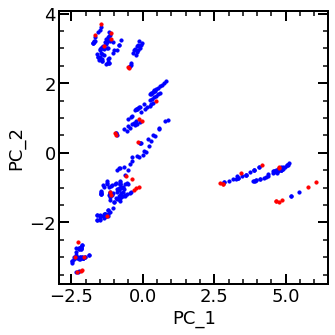

In [11]:
# データの分布を主成分分析（PCA）で表現してみる
pca = PCA()
X_train_pca = pca.fit_transform(sX_train)
X_testH2_pca = pca.transform(sX_testH2)
X_testC2H2_pca = pca.transform(X_testC2H2)
X_testC2H4_pca = pca.transform(X_testC2H4)
X_testC2H6_pca = pca.transform(X_testC2H4)
X_testC2H4_pca = pca.transform(X_testC2H4)

# フォントを変更
plt.rcParams["font.family"] = "Arial"

# Plot のインスタンスと図の大きさを定義
fig = plt.figure(figsize = (10, 10))

# インスタンスの中に複数のグラフを作る場合に指定
# 引数は（行数、列数、具体的に作りたい図のインデックス）
# グラフを 1 つだけ作りたいときは (1, 1, 1)としてやれば良い

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(X_train_pca[y_train_class == 1, 0], X_train_pca[y_train_class == 1, 1],s=10,color='blue')
plt.scatter(X_train_pca[y_train_class == -1, 0], X_train_pca[y_train_class == -1, 1],s=10,color='red')

plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.tight_layout()
plt.savefig("gurafu1(OCSVM).png")

/home/hiroki/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


8.090036463376686 0.9654899243758128
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 200, 200, 200, 200, 200), 'solver': 'adam'}
Best cross-validation: 0.9274996665384195
0.8010371819976594 0.9630170298558157 H2
-0.5235379699478162 0.6816156351679272 C2H2
0.7458930336469678 0.7337993674374236 C2H4
0.922091191549818 0.9359796102985309 C2H6
0.8607585642996594 0.8279435276800533 C2H2Ar


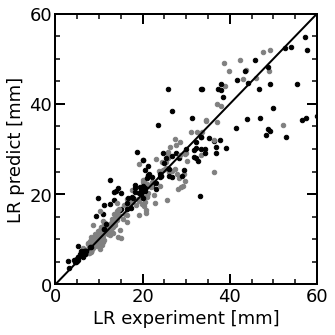

In [23]:

sol=['adam']
act=['relu']
hidd=[]

for i in [6]:
    for j in [200]:
        b=[j]*i
        b=tuple(b)
        hidd.append(b)

alp=[1e-4]
param_grid = {'solver':sol,'activation':act,'hidden_layer_sizes':hidd,'alpha':alp}
from sklearn.linear_model import LinearRegression
grid1=GridSearchCV(MLPRegressor(), param_grid , cv=3, n_jobs=4)
grid1.fit(X_train,y_train)
#grid1 = LinearRegression().fit(sX_train,y_train)
#print(pd.DataFrame(list(grid1.coef_),index=sX_train.columns))

result1 = grid1.predict(X_train)
MSE1=mean_squared_error(y_train, result1)
R1=r2_score(y_train, result1)

print(MSE1,R1)

print('Best parameters: {}'.format(grid1.best_params_))
print('Best cross-validation: {}'.format(grid1.best_score_))

resultH2=grid1.predict(X_testH2)
MSEH2=mean_squared_error(yH2test, resultH2)
R2H2=r2_score(yH2test,resultH2)

resultC2H2=grid1.predict(X_testC2H2)
MSEC2H2=mean_squared_error(yC2H2test, resultC2H2)
R2C2H2=r2_score(yC2H2test,resultC2H2)

resultC2H4=grid1.predict(X_testC2H4)
MSEC2H4=mean_squared_error(yC2H4test, resultC2H4)
R2C2H4=r2_score(yC2H4test,resultC2H4)

resultC2H6=grid1.predict(X_testC2H6)
MSEC2H6=mean_squared_error(yC2H6test, resultC2H6)
R2C2H6=r2_score(yC2H6test,resultC2H6)

resultC2H2AR=grid1.predict(X_testC2H2Ar)
MSEC2H2AR=mean_squared_error(yC2H2ARtest, resultC2H2AR)
R2C2H2AR=r2_score(yC2H2ARtest,resultC2H2AR)

resultC2H4AR=grid1.predict(X_testC2H4Ar)
MSEC2H4AR=mean_squared_error(yC2H4ARtest, resultC2H4AR)
R2C2H4AR=r2_score(yC2H4ARtest,resultC2H4AR)

plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5


plt.plot([0, 60], [0, 60],color='black')

# データをプロットする
plt.scatter(yH2test[y_test_classH2 == 1], resultH2[y_test_classH2 == 1],s=20,color='grey', label = "AD_inside")
plt.scatter(yH2test[y_test_classH2 == -1], resultH2[y_test_classH2 == -1],s=20,color='black', label = "AD_outside")
plt.scatter(yC2H2test[y_test_classC2H2 == 1], resultC2H2[y_test_classC2H2 == 1],s=20,color='grey', label = "AD_inside")
plt.scatter(yC2H2test[y_test_classC2H2 == -1], resultC2H2[y_test_classC2H2 == -1],s=20,color='black', label = "AD_outside")
plt.scatter(yC2H4test[y_test_classC2H4 == 1], resultC2H4[y_test_classC2H4 == 1],s=20,color='grey', label = "AD_inside")
plt.scatter(yC2H4test[y_test_classC2H4 == -1], resultC2H4[y_test_classC2H4 == -1],s=20,color='black', label = "AD_outside")
plt.scatter(yC2H6test[y_test_classC2H6 == 1], resultC2H6[y_test_classC2H6 == 1],s=20,color='grey', label = "AD_inside")
plt.scatter(yC2H6test[y_test_classC2H6 == -1], resultC2H6[y_test_classC2H6 == -1],s=20,color='black', label = "AD_outside")
plt.scatter(yC2H2ARtest[y_test_classC2H2Ar == 1], resultC2H2AR[y_test_classC2H2Ar == 1],s=20,color='grey', label = "AD_inside")
plt.scatter(yC2H2ARtest[y_test_classC2H2Ar == -1], resultC2H2AR[y_test_classC2H2Ar == -1],s=20,color='black', label = "AD_outside")
plt.scatter(yC2H4ARtest[y_test_classC2H4Ar == 1], resultC2H4AR[y_test_classC2H4Ar == 1],s=20,color='grey', label = "AD_inside")
plt.scatter(yC2H4ARtest[y_test_classC2H4Ar == -1], resultC2H4AR[y_test_classC2H4Ar == -1],s=20,color='black', label = "AD_outside")

plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xticks(np.arange(0, 61, step=20))
plt.yticks(np.arange(0, 61, step=20))
plt.xlabel('LR experiment [mm]')
plt.ylabel('LR predict [mm]')
plt.tight_layout()
plt.savefig("gurafu2(OCSVM).png")

# AD 内のデータについて R2 値を算出# AD 外のデータについて R2 値を算出
print(r2_score(yH2test[y_test_classH2 == 1], resultH2[y_test_classH2 == 1]),r2_score(yH2test[y_test_classH2 == -1], resultH2[y_test_classH2 == -1]),'H2')
print(r2_score(yC2H2test[y_test_classC2H2 == 1], resultC2H2[y_test_classC2H2 == 1]),r2_score(yC2H2test[y_test_classC2H2 == -1], resultC2H2[y_test_classC2H2 == -1]),'C2H2')
print(r2_score(yC2H4test[y_test_classC2H4 == 1], resultC2H4[y_test_classC2H4 == 1]),r2_score(yC2H4test[y_test_classC2H4 == -1], resultC2H4[y_test_classC2H4 == -1]),'C2H4')
print(r2_score(yC2H6test[y_test_classC2H6 == 1], resultC2H6[y_test_classC2H6 == 1]),r2_score(yC2H6test[y_test_classC2H6 == -1], resultC2H6[y_test_classC2H6 == -1]),'C2H6')
print(r2_score(yC2H2ARtest[y_test_classC2H2Ar == 1], resultC2H2AR[y_test_classC2H2Ar == 1]),r2_score(yC2H2ARtest[y_test_classC2H2Ar == -1], resultC2H2AR[y_test_classC2H2Ar == -1]),'C2H2Ar')
#print(r2_score(yC2H4ARtest[y_test_classC2H4Ar == 1], resultC2H4AR[y_test_classC2H4Ar == 1]),r2_score(yC2H4ARtest[y_test_classC2H4Ar == -1],resultC2H4AR[y_test_classC2H4Ar == -1]),'C2H4Ar')
#print(r2_score(yC2H4ARtest[y_test_classC2H4Ar == 1], resultC2H4AR[y_test_classC2H4Ar == 1]),r2_score(yC2H4ARtest[y_test_classC2H4Ar == -1], resultC2H4AR[y_test_classC2H4Ar == -1]),'C2H4Ar')